In [1]:
import sys
sys.path.insert(0, "../../../")

In [2]:
import deeplay as dl
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torchvision
import lightning as L

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
# Load the MNIST dataset and normalize it to [-1, 1]

mnist = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

mnist_test = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [4]:
mnist_dataloader = torch.utils.data.DataLoader(mnist, batch_size=32, num_workers=4)
mnist_test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=32, num_workers=0)

In [5]:

def generate_examples(model, latent_range, n=5):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch
    plt.figure(figsize=(10, 10))
    x = np.linspace(latent_range[0][0], latent_range[1][0], n)
    y = np.linspace(latent_range[0][1], latent_range[1][1], n)

    xx, yy = np.meshgrid(x, y)
    xx = torch.tensor(xx).float()
    yy = torch.tensor(yy).float()
    z = torch.stack([xx, yy], dim=-1).view(-1, 2)
    yhat = model.decode(z).detach().cpu().numpy()

    for i in range(n ** 2):
        plt.subplot(n, n, i + 1)
        plt.imshow(yhat[i].transpose((1, 2, 0)), cmap="Greys_r")
        plt.axis("off")

    plt.tight_layout()


    

In [6]:


def scatterplot(model, testset):
    import matplotlib.pyplot as plt
    import numpy as np
    import torchvision
    import torch

    xy = torch.zeros((len(testset) * 32, 2))
    test_classes = torch.zeros((len(testset) * 32))

    i0 = 0
    for i, (x, y) in enumerate(testset):
        yhat = model.encode(x.view(-1, 1, 28, 28)).detach().cpu()
        xy[i:i + len(yhat)] = yhat
        test_classes[i:i + len(yhat)] = y.cpu().view(-1)

    latent_range = (
        xy.min(dim=0)[0],
        xy.max(dim=0)[0],
    )
   
    plt.figure(figsize=(10, 10))
    plt.scatter(xy[:, 0], xy[:, 1], c=test_classes, cmap="jet")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return latent_range

### 1.2 Autoencoder

Regular autoencoders have four steps: `encoder`, `bottleneck`, `decoder` and `head`. The encoder takes the input data and returns a transformation of the input. This would typically be a downsampled representation. The bottleneck takes the downsampled representation and produces the latent vector. The decoder decodes the latent back to the input modality. The head ensures the output is compatible with the input.

In [7]:
class ResidualSpatialDecoder(dl.SpatialBroadcastDecoder2d):

    def forward(self, z):

        x = self.input_block(z)
        output_size = self.output_size
        x = self.broadcast(x, output_size)


        for block in self.decoder_blocks:
            x = block(self.encoding(x)) + x

        x = self.output_block(x)

        return x

In [8]:
double_conv_template = (
    dl.Layer("layer") >> dl.Layer("activation") >> dl.Layer("layer") >> dl.Layer("activation")
)

autoencoder = dl.VariationalAutoencoder.from_config(
    dl.Config()
    .hidden_dim(2)
    .encoder.depth(3)
    .decoder.depth(4)
    .decoder(ResidualSpatialDecoder)
    .decoder.input_block(nn.LazyLinear, out_features=128)
    .decoder.decoder_blocks(double_conv_template)
    .decoder.decoder_blocks.activation(nn.LeakyReLU, negative_slope=0.1)
    .decoder.decoder_blocks.layer(kernel_size=1, padding=0, out_channels=128)
    .loss(nn.BCELoss(reduction="sum"))
    .optimizer(torch.optim.Adam, lr=2e-4)

)
autoencoder(torch.rand(1, 1, 28, 28))
autoencoder.to("cuda")
autoencoder

c:\users\gu\deeptorch\deeplay\components\encodings\positional\linear.py:35: UserWarning: Using linear positional encoding with large latent dimensions is unlikely to work well.Consider using sinusoidal positional encoding instead.
  warnings.warn(
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


VariationalAutoencoder(
  (encoder): ImageToImageEncoder(
    (depth): 3
    (input_block): Template(
      (layer): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (activation): ReLU()
    )
    (encoder_blocks): ModuleList(
      (0): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Template(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
    )
    (output_block): Identity()
  )
  (bottleneck

In [9]:
trainer = L.Trainer(max_epochs=100, accelerator="auto")
trainer.fit(autoencoder, mnist_dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                   | Params
------------------------------------------------------
0 | encoder    | ImageToImageEncoder    | 97.2 K
1 | bottleneck | VariationalBottleneck  | 4.6 K 
2 | decoder    | ResidualSpatialDecoder | 133 K 
3 | head       | ImageRegressionHead    | 129   
4 | loss       | BCELoss                | 0     
------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.942     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
trainer.test(dataloaders=mnist_test_dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\checkpoint_connector.py:134: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at c:\Users\GU\DeepTorch\tutorials\examples\vision\autoencoders\lightning_logs\version_7\checkpoints\epoch=85-step=161250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at c:\Users\GU\DeepTorch\tutorials\examples\vision\autoencoders\lightning_logs\version_7\checkpoints\epoch=85-step=161250.ckpt
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have m

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       kl_loss_epoch       │    215.88882446289062     │
│ reconstruction_loss_epoch │      4417.2958984375      │
│         test_loss         │     4633.18408203125      │
└───────────────────────────┴───────────────────────────┘

[{'reconstruction_loss_epoch': 4417.2958984375,
  'kl_loss_epoch': 215.88882446289062,
  'test_loss': 4633.18408203125}]

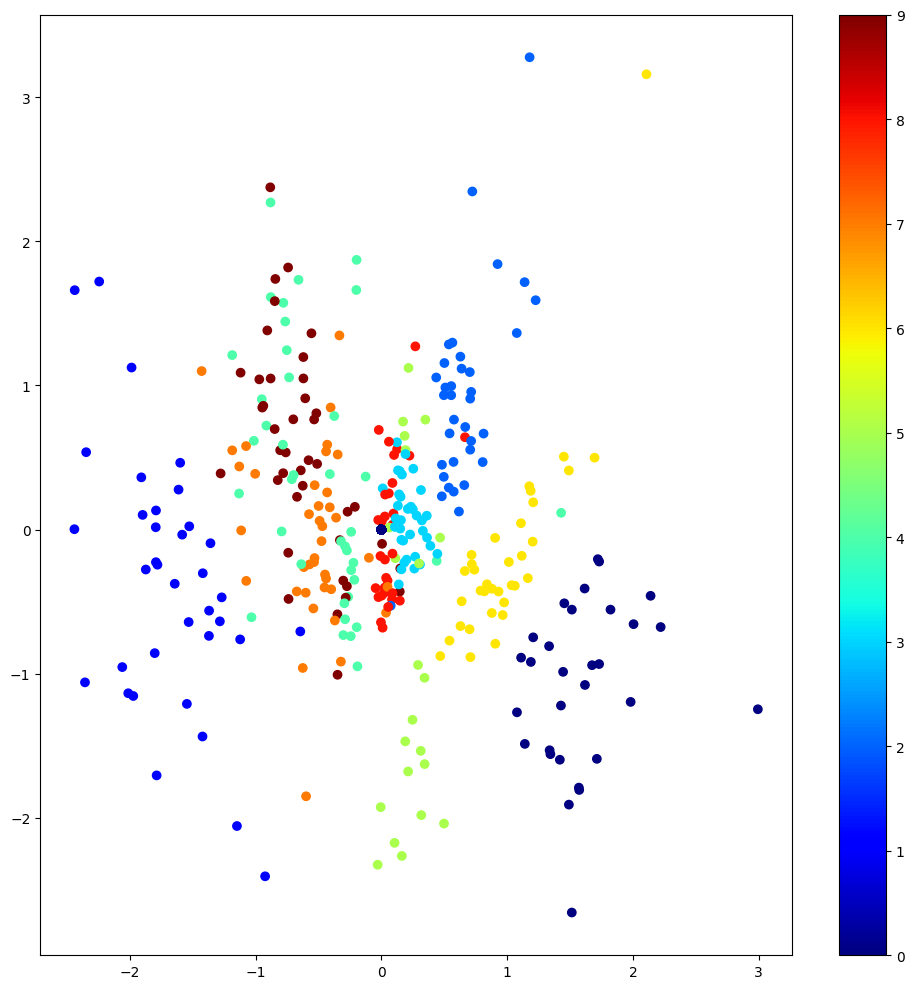

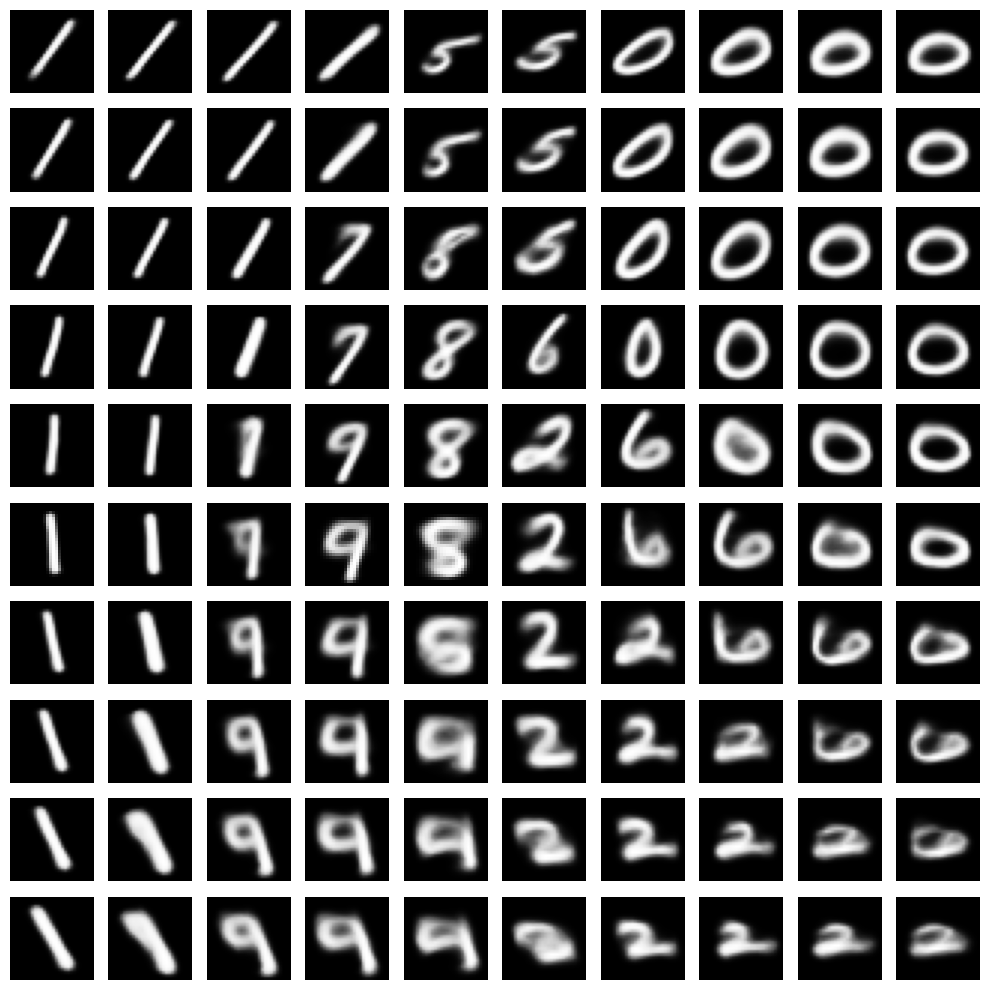

In [11]:
latent_range = scatterplot(autoencoder, mnist_test_dataloader)
generate_examples(autoencoder, latent_range, n=10)